In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from joblib import dump
from src.models import eval_model as evm
from src.models import eval_baseline as evb
from data import clean_and_split_nba_data as clean
from models import plot_validation_curve as vc
%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv("../data/raw/train.csv")
df

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,10556,3799,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,...,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6,1
1,5342,3800,75,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,...,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4,1
2,5716,3801,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,...,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6,1
3,13790,3802,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,...,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9,1
4,5470,3803,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,...,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,2996,11794,32,9.2,1.8,0.7,1.8,40.3,-0.1,-0.2,...,0.6,65.7,0.3,1.8,1.9,0.5,0.3,0.2,0.4,1
7996,11679,11795,54,6.0,1.8,0.7,1.4,48.7,0.1,0.1,...,0.4,70.1,1.0,1.1,2.0,0.1,0.0,0.3,0.3,1
7997,5537,11796,85,28.2,10.7,4.0,9.0,45.1,0.2,0.6,...,3.9,69.7,1.0,2.1,3.1,3.4,1.2,0.2,1.8,1
7998,1292,11797,39,7.7,2.5,1.0,2.3,40.1,-0.3,-0.5,...,0.7,74.3,0.4,0.6,0.9,0.2,0.3,0.3,0.5,1


In [3]:
df_clean = df.copy()

In [4]:
df_clean.shape

(8000, 22)

In [5]:
df_clean.drop(['Id_old','Id','TARGET_5Yrs'],axis=1,inplace=True)
df_clean

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,22.6,2.0,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6
1,75,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,34.9,2.4,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4
2,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,34.3,0.4,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6
3,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,23.7,0.9,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9
4,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,13.7,0.2,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,32,9.2,1.8,0.7,1.8,40.3,-0.1,-0.2,23.1,0.4,0.6,65.7,0.3,1.8,1.9,0.5,0.3,0.2,0.4
7996,54,6.0,1.8,0.7,1.4,48.7,0.1,0.1,3.1,0.2,0.4,70.1,1.0,1.1,2.0,0.1,0.0,0.3,0.3
7997,85,28.2,10.7,4.0,9.0,45.1,0.2,0.6,23.6,2.8,3.9,69.7,1.0,2.1,3.1,3.4,1.2,0.2,1.8
7998,39,7.7,2.5,1.0,2.3,40.1,-0.3,-0.5,13.3,0.6,0.7,74.3,0.4,0.6,0.9,0.2,0.3,0.3,0.5


In [6]:
x_data, x_train, x_val, x_test, y_data , y_train, y_val,  y_test = clean.clean_and_split_nba_data(df)

Index(['GP', 'MIN', 'PTS', 'FGM', 'FGA', '3P Made', '3PA', 'FTM', 'FTA',
       'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'CALC3P%', 'CALCFG%',
       'CALCFT%'],
      dtype='object')


In [ ]:
x_data.drop(['GP'],axis=1, inplace=True)
x_train.drop(['GP'],axis=1, inplace=True)
x_val.drop(['GP'],axis=1, inplace=True)
x_test.drop(['GP'],axis=1, inplace=True)

In [ ]:
x_data.shape

In [ ]:
x_train.columns, x_val.columns, x_test.columns, 

Accuracy Score:  0.83359375  F1 Score  0.9092458457605455  Precision Score  0.83359375  Recall Score  1.0 (BASELINE)


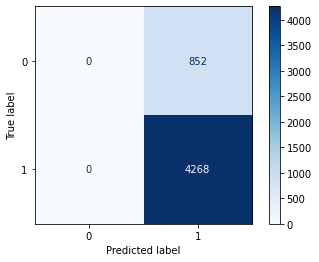

In [7]:
evb.eval_baseline(x_train,y_train)

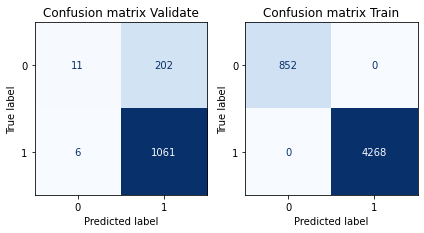

RandomForestClassifier(random_state=8)


(RandomForestClassifier(random_state=8), 1.0, 0.6739861222945294)

In [8]:
evm.eval_model(RandomForestClassifier(random_state=8),x_train,y_train,x_val,y_val)

In [ ]:
evm.eval_model(RandomForestClassifier(random_state=8,class_weight={0:0.84,1:0.16}),x_train,y_train,x_val,y_val)

In [ ]:
vc.plot_validation_curve(estimator=RandomForestClassifier(random_state=8,class_weight={0:0.84,1:0.16}),
                    hyperparameter='min_samples_leaf',
                    hyperparameter_value=range(1,1000,100),
                    x=x_data,
                    y=y_data,
                    title="RandomForestClassifier",
                    cv=5)

In [ ]:
vc.plot_validation_curve(estimator=RandomForestClassifier(random_state=8,class_weight={0:0.84,1:0.16}),
                    hyperparameter='min_samples_leaf',
                    hyperparameter_value=range(900,1000,20),
                    x=x_data,
                    y=y_data,
                    title="RandomForestClassifier",
                    cv=5)

In [ ]:
vc.plot_validation_curve(estimator=RandomForestClassifier(random_state=8,class_weight={0:0.84,1:0.16}),
                    hyperparameter='min_samples_leaf',
                    hyperparameter_value=range(1000,2000,100),
                    x=x_data,
                    y=y_data,
                    title="RandomForestClassifier",
                    cv=5)

In [ ]:
vc.plot_validation_curve(estimator=RandomForestClassifier(random_state=8,class_weight={0:0.84,1:0.16}),
                    hyperparameter='min_samples_leaf',
                    hyperparameter_value=range(1500,1690,10),
                    x=x_data,
                    y=y_data,
                    title="RandomForestClassifier",
                    cv=5)

In [ ]:
vc.plot_validation_curve(estimator=RandomForestClassifier(random_state=8,class_weight={0:0.84,1:0.16}),
                    hyperparameter='min_samples_leaf',
                    hyperparameter_value=range(1500,1640,10),
                    x=x_data,
                    y=y_data,
                    title="RandomForestClassifier",
                    cv=5)

In [ ]:
vc.plot_validation_curve(estimator=RandomForestClassifier(random_state=8,class_weight={0:0.84,1:0.16}),
                    hyperparameter='min_samples_leaf',
                    hyperparameter_value=range(1610,1640,10),
                    x=x_data,
                    y=y_data,
                    title="RandomForestClassifier",
                    cv=5)

In [ ]:
vc.plot_validation_curve(estimator=RandomForestClassifier(random_state=8,class_weight={0:0.84,1:0.16}),
                    hyperparameter='min_samples_leaf',
                    hyperparameter_value=range(1615,1625,1),
                    x=x_data,
                    y=y_data,
                    title="RandomForestClassifier",
                    cv=5)

In [ ]:
vc.plot_validation_curve(estimator=RandomForestClassifier(random_state=8,min_samples_leaf=1619,class_weight={0:0.84,1:0.16}),
                    hyperparameter='max_features',
                    hyperparameter_value=range(1,18,1),
                    x=x_data,
                    y=y_data,
                    title="RandomForestClassifier",
                    cv=5)

In [ ]:
vc.plot_validation_curve(estimator=RandomForestClassifier(random_state=8,min_samples_leaf=1619,class_weight={0:0.84,1:0.16}),
                    hyperparameter='max_features',
                    hyperparameter_value=[3,4,5,10,11,12],
                    x=x_data,
                    y=y_data,
                    title="RandomForestClassifier",
                    cv=5)

In [ ]:
vc.plot_validation_curve(estimator=RandomForestClassifier(random_state=8,min_samples_leaf=1619,max_features=10,class_weight={0:0.84,1:0.16}),
                    hyperparameter='max_depth',
                    hyperparameter_value=range(1,100,10),
                    x=x_data,
                    y=y_data,
                    title="RandomForestClassifier",
                    cv=5)

In [ ]:
vc.plot_validation_curve(estimator=RandomForestClassifier(random_state=8,min_samples_leaf=1619,max_features=10,class_weight={0:0.84,1:0.16}),
                    hyperparameter='n_estimators',
                    hyperparameter_value=range(1,500,50),
                    x=x_data,
                    y=y_data,
                    title="RandomForestClassifier",
                    cv=5)

In [ ]:
vc.plot_validation_curve(estimator=RandomForestClassifier(random_state=8,min_samples_leaf=1619,max_features=10,class_weight={0:0.84,1:0.16}),
                    hyperparameter='n_estimators',
                    hyperparameter_value=range(100,500,100),
                    x=x_data,
                    y=y_data,
                    title="RandomForestClassifier",
                    cv=5)

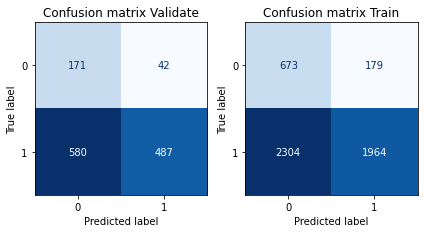

RandomForestClassifier(class_weight={0: 0.84, 1: 0.16}, max_features=10,
                       min_samples_leaf=1619, random_state=8)


(RandomForestClassifier(class_weight={0: 0.84, 1: 0.16}, max_features=10,
                        min_samples_leaf=1619, random_state=8),
 0.6736445696987298,
 0.7034641463275121)

In [9]:
rf1=RandomForestClassifier(random_state=8,min_samples_leaf=1619,max_features=10,class_weight={0:0.84,1:0.16})
evm.eval_model(rf1,x_train,y_train,x_val,y_val)

Accuracy Score:  0.83359375  F1 Score  0.9092458457605455  Precision Score  0.83359375  Recall Score  1.0 (BASELINE)


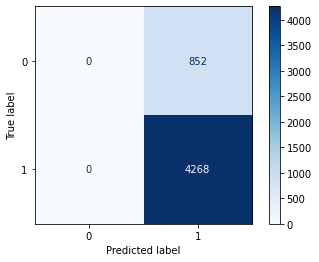

In [10]:
evb.eval_baseline(x_train,y_train)

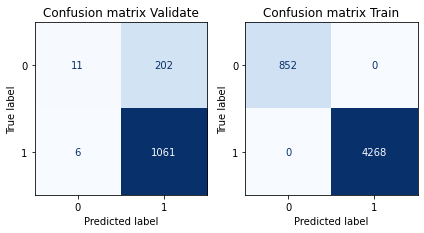

RandomForestClassifier(random_state=8)


(RandomForestClassifier(random_state=8), 1.0, 0.6739861222945294)

In [11]:
evm.eval_model(RandomForestClassifier(random_state=8),x_train,y_train,x_val,y_val)